PGM HW1

--- 



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm
from scipy.special import logsumexp


In [2]:
if not os.path.isdir('Data'):
    os.makedirs('Data')


In [3]:

data = "/content/Data"
my_list = [("trainA","testA"),("trainB","testB"),("trainC","testC")]


## Exercice 1

### 1) Generative model (LDA)

LDA classification: learnt parameters on trainA:

pi = 0.48, mu0=[10.73248858 10.93983367], mu1=[11.03264581  5.99294053], sigma=[[0.58821974 0.13912842]
 [0.13912842 0.81959919]]


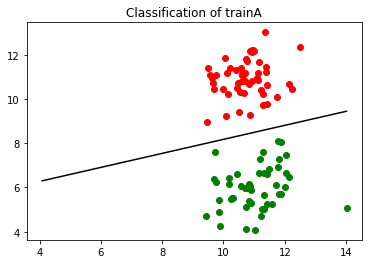

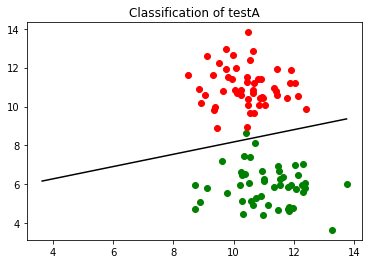

LDA classification: learnt parameters on trainB:

pi = 0.55, mu0=[10.58256756 11.17169818], mu1=[11.24757662  6.095283  ], sigma=[[1.64391088 0.70139847]
 [0.70139847 2.0605845 ]]


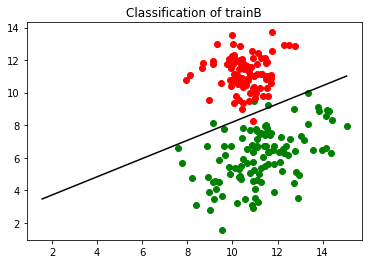

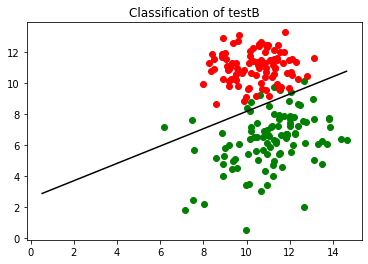

LDA classification: learnt parameters on trainC:

pi = 0.4166666666666667, mu0=[10.6192273  10.83868653], mu1=[11.18463199  6.04249315], sigma=[[ 1.27823018 -0.06243809]
 [-0.06243809  1.66584186]]


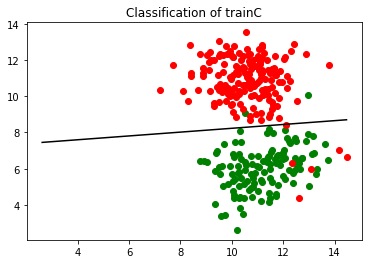

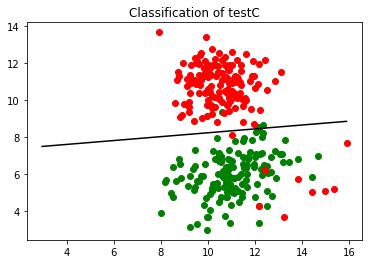

In [ ]:
def pi_mle(Y):
    n = Y.shape[0]
    return 1/n * np.sum(Y)

def mu_mle(X,Y):
  d = X.shape[1]
  n = X.shape[0]
  xy = np.zeros(d)
  Y_bar = 0
  x_bar = 0
  for i in range(0,n):
    x_bar += X[i]
    xy += Y[i] * X[i]
    Y_bar += Y[i]
  mu1 = xy / Y_bar
  mu0 = (x_bar - xy) / (n - Y_bar)
  return mu0, mu1

def sigma_mle(X,Y,mu0,mu1):
    d = X.shape[1]
    n = X.shape[0]
    sigma = np.zeros([d,d])
    for i in range(0,n):     
        vec0 = X[i] - mu0
        vec1 = X[i] - mu1
        sigma += Y[i] * np.outer(vec1, vec1.T) + (1 - Y[i]) * np.outer(vec0, vec0.T)
    return sigma / n

def MLE(X,Y):
    pi = pi_mle(Y)
    mu0,mu1 = mu_mle(X,Y)
    sigma = sigma_mle(X,Y,mu0,mu1)
    return pi, mu0, mu1, sigma

def pred_LDA(pi,mu0,mu1,sigma,X):
    inv_sigma = np.linalg.inv(sigma)
    w = inv_sigma.dot(mu1-mu0)
    b = 1/2 * (mu0.T.dot(inv_sigma.dot(mu0)) - mu1.T.dot(inv_sigma.dot(mu1)))
    y = 1/ (1 + (1 - np.pi) / np.pi * np.exp(-(w.T.dot(X.T) + b)))
    return np.round_(y)
    
def line(A,pi, mu0,mu1, sigma):
    sigma_inv = np.linalg.inv(sigma)
    w = sigma_inv.dot(mu1 - mu0)
    b = 0.5 * mu0.T.dot(sigma_inv).dot(mu0) - 0.5 * mu1.T.dot(sigma_inv).dot(mu1)
    x1 = min(A[:,1])
    x2 = max(A[:,0])
    y1 = (-np.log(pi/(1-pi))-b- x1*w[0]) / w[1]
    y2= (-np.log(pi / (1 - pi)) - b - x2 *w[0]) / w[1]
    return x1,y1,x2,y2

def scatter(A,pi,mu0,mu1,sigma,set_nb):
    plt.scatter(A[np.where(A[:,2]==1),0],A[np.where(A[:,2]==1),1], c='green')
    plt.scatter(A[np.where(A[:,2]==0),0],A[np.where(A[:,2]==0),1], c='red')
    x1,y1,x2,y2 = line(A,pi, mu0,mu1, sigma)
    plt.plot([x1, x2],[y1, y2], c="black")
    plt.title("Classification of " + set_nb)
    plt.show()

for ele in my_list:
    train = pd.read_csv(data + "/" + ele[0], header=None, sep=" ").to_numpy()
    test = pd.read_csv(data + "/" + ele[1], header=None, sep=" ").to_numpy()
    #classify trainA
    X_train = train[:,0:2]
    Y_train = train[:,2]
    pi, mu0,mu1, sigma = MLE(X_train,Y_train)
    print("LDA classification: learnt parameters on {}:\n".format(ele[0]))
    print("pi = {}, mu0={}, mu1={}, sigma={}".format(pi, mu0, mu1, sigma))
    scatter(train, pi, mu0,mu1, sigma, ele[0])
    scatter(test, pi, mu0,mu1, sigma, ele[1])

## 2) Logistic regression

logistic regression: learnt parameters on trainA:

w1=2.3285, w2=-7.5721, b=39.8215 (rounded to 4 digits of precision)


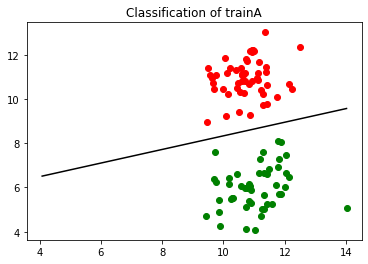

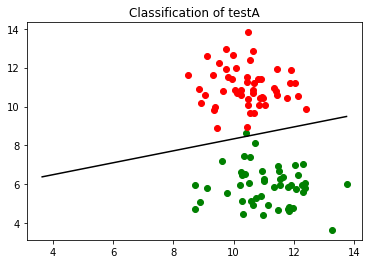

logistic regression: learnt parameters on trainB:

w1=1.8424, w2=-3.7139, b=13.4302 (rounded to 4 digits of precision)


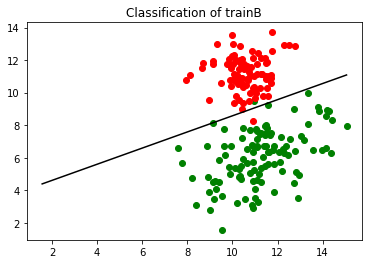

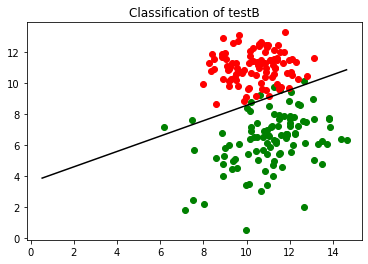

logistic regression: learnt parameters on trainC:

w1=-0.2769, w2=-1.9142, b=18.8070 (rounded to 4 digits of precision)


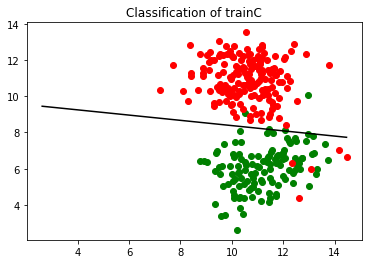

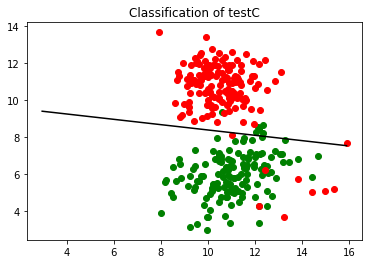

In [ ]:
def sigmoid(x):
    # return the sigmoid function in x
    return 1 / (1 + np.exp(-x))

def h_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def f(X,W):
    return W.T.dot(X).T

def log_likelyhood(W,Y,X):
    return Y.dot(np.log(sigmoid(f(X,W)))) + (1 - Y).dot(np.log(1 - sigmoid(f(X,W))))

def IRLS(X, Y, n_iter=100):
    incre = 10
    W = np.zeros(3)
    #W = np.random.rand(d+1)
    for i in range(0,n_iter):
        W_n = np.copy(W)
    #while np.sum(abs(incre)>eps):
        mu = np.squeeze(sigmoid(f(X,W)))
        D = np.diag(mu *(1-mu))
        if np.linalg.det(X.dot(D.dot(X.T)))==0:
            return W
        inv = np.linalg.inv(X.dot(D.dot(X.T)))
        incre = inv.dot(X.dot(Y - mu))
        W += incre
        if not ((sigmoid(f(X,W))>0).all() and (sigmoid(f(X,W))<1).all()):
            return W_n
    return W

def p(X,W):
    return sigmoid(f(X,W))

def pred_logi(X,W):
    return np.round(p(X,W))


def line_logistic(A,W):
    x1 = min(A[:,1])
    x2 = max(A[:,0])
    y1 = (-W[2]-W[0]*x1) / W[1]
    y2 = (-W[2]-W[0]*x2) / W[1]
    return x1,y1,x2,y2

def scatter(A,W,set_nb):
    plt.scatter(A[np.where(A[:,2]==1),0],A[np.where(A[:,2]==1),1], c='green')
    plt.scatter(A[np.where(A[:,2]==0),0],A[np.where(A[:,2]==0),1], c='red')
    x1,y1,x2,y2 = line_logistic(A,W)
    plt.plot([x1, x2],[y1, y2], c="black")
    plt.title("Classification of " + set_nb)
    plt.show()
    
for ele in my_list:
    train = pd.read_csv(data + "/" + ele[0], header=None, sep=" ").to_numpy()
    test = pd.read_csv(data + "/" + ele[1], header=None, sep=" ").to_numpy()
    X_train = train[:,0:2]
    Y_train = train[:,2]
    n_train = X_train.shape[0]
    #modification of X_train 
    X_train = np.hstack((X_train, np.ones(n_train).reshape(n_train,1))).T
    W = IRLS(X_train, Y_train)
    print("logistic regression: learnt parameters on {}:\n".format(ele[0]))
    print("w1={:.4f}, w2={:01.4f}, b={:01.4f} (rounded to 4 digits of precision)".format(W[0],W[1],W[2]))
    scatter(train, W, ele[0])
    scatter(test, W, ele[1])

## 3) Linear regression

Linear regression: learnt parameters on trainA:

w1=0.0558, w2=-0.1764, b=1.3835 (rounded to 4 digits of precision)


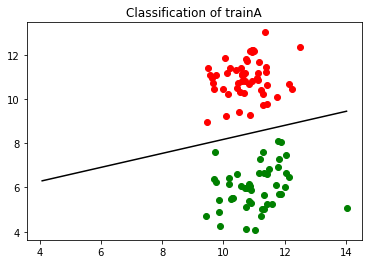

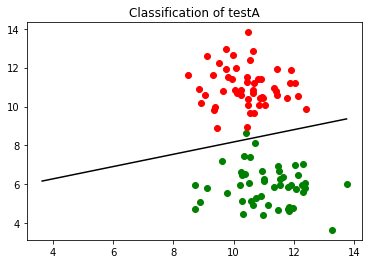

Linear regression: learnt parameters on trainB:

w1=0.0826, w2=-0.1476, b=0.8825 (rounded to 4 digits of precision)


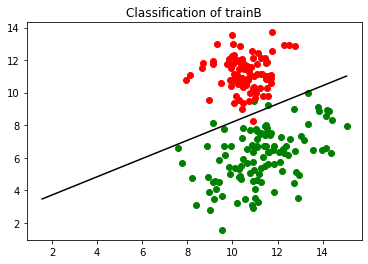

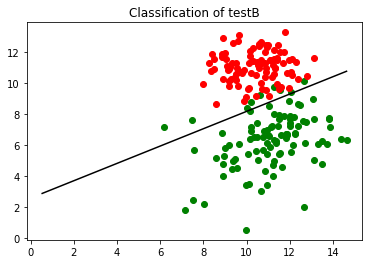

Linear regression: learnt parameters on trainC:

w1=0.0168, w2=-0.1590, b=1.6402 (rounded to 4 digits of precision)


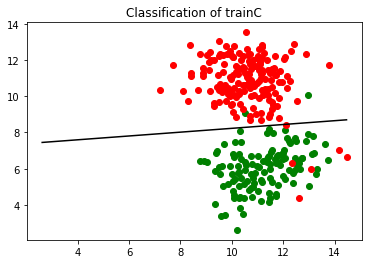

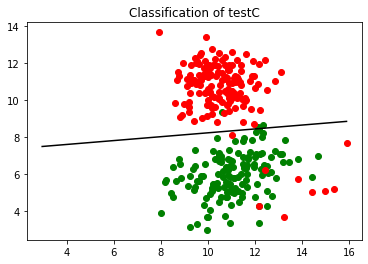

In [ ]:
def estim_W(X,Y):
    inv = np.linalg.inv(X.T@X)
    w = inv.dot(X.T.dot(Y))
    return w

def pred_linear(X,W):
    return np.round_(W.dot(X.T))

def line_regression(A,W):
    x1 = min(A[:,1])
    x2 = max(A[:,0])
    y1 = (-W[2] - W[0] * x1 + 0.5) / W[1]
    y2 = (-W[2] - W[0] * x2 + 0.5  ) / W[1]
    return x1,y1,x2,y2

def scatter(A,W,set_nb):
    plt.scatter(A[np.where(A[:,2]==1),0],A[np.where(A[:,2]==1),1], c='green')
    plt.scatter(A[np.where(A[:,2]==0),0],A[np.where(A[:,2]==0),1], c='red')
    x1,y1,x2,y2 = line_regression(A,W)
    plt.plot([x1, x2],[y1, y2], c="black")
    plt.title("Classification of " + set_nb)
    plt.show()

for ele in my_list:
    train = pd.read_csv(data + "/" + ele[0], header=None, sep=" ").to_numpy()
    test = pd.read_csv(data + "/" + ele[1], header=None, sep=" ").to_numpy()
    X_train = train[:,0:2]
    Y_train = train[:,2]
    n_train = X_train.shape[0]
    #modification of X_train 
    X_train = np.hstack((X_train, np.ones(n_train).reshape(n_train,1)))
    W = estim_W(X_train,Y_train)
    print("Linear regression: learnt parameters on {}:\n".format(ele[0]))
    print("w1={:.4f}, w2={:01.4f}, b={:01.4f} (rounded to 4 digits of precision)".format(W[0],W[1],W[2]))
    scatter(train, W, ele[0])
    scatter(test, W, ele[1])

## Application

In [ ]:
def missclassify(X_train,Y_train,X_test,Y_test,model):
    d = 2
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    if model == "linear_regression":
        X_train = np.hstack((X_train, np.ones(n_train).reshape(n_train,1)))
        X_test = np.hstack((X_test, np.ones(n_test).reshape(n_test,1)))
        W = np.ones([d+1])
        W = estim_W(X_train,Y_train)
        #prediction
        Y_pred_train = pred_linear(X_train,W)
        Y_pred_test = pred_linear(X_test,W)
        
    elif model == "logistic_regression":
        X_train = np.hstack((X_train, np.ones(n_train).reshape(n_train,1))).T
        X_test = np.hstack((X_test, np.ones(n_test).reshape(n_test,1))).T
        W = IRLS(X_train, Y_train)
        #prediction
        Y_pred_train = pred_logi(X_train,W)
        Y_pred_test = pred_logi(X_test,W)
        
    elif model =="LDA":
        pi, mu0,mu1, sigma = MLE(X_train,Y_train)
        #prediction
        Y_pred_train = pred_LDA(pi,mu0,mu1,sigma,X_train)
        Y_pred_test = pred_LDA(pi,mu0,mu1,sigma,X_test)
        
    #compute missclassification
    missclass_train = sum(abs(Y_pred_train - Y_train))
    missclass_test = sum(abs(Y_pred_test - Y_test))                  
    return missclass_train/n_train, missclass_test/n_test


for ele in my_list:
    train = pd.read_csv(data + "/" + ele[0], header=None, sep=" ").to_numpy()
    test = pd.read_csv(data + "/" + ele[1], header=None, sep=" ").to_numpy()
    X_train = train[:,0:2]
    Y_train = train[:,2]
    X_test = test[:,0:2]
    Y_test = test[:,2]
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    #models= ["LDA","linear_regression"]
    models= ["LDA","logistic_regression","linear_regression"]
    print("Missclassification error on set {}".format(ele[0][-1]))
    for model in models:
        miss_class_train, miss_class_test = missclassify(X_train,Y_train,X_test,Y_test,model)
        print("{} on {} : {:.1f}% ".format(model,ele[0], miss_class_train * 100))
        print("{} on {}: {:.1f}% : ".format(model,ele[1], miss_class_test * 100) )
        print()
    print("\n \n")

Missclassification error on set A
LDA on trainA : 0.0% 
LDA on testA: 1.0% : 

logistic_regression on trainA : 0.0% 
logistic_regression on testA: 1.0% : 

linear_regression on trainA : 0.0% 
linear_regression on testA: 1.0% : 


 

Missclassification error on set B
LDA on trainB : 5.5% 
LDA on testB: 10.5% : 

logistic_regression on trainB : 1.0% 
logistic_regression on testB: 3.5% : 

linear_regression on trainB : 2.0% 
linear_regression on testB: 5.5% : 


 

Missclassification error on set C
LDA on trainC : 7.0% 
LDA on testC: 8.7% : 

logistic_regression on trainC : 3.0% 
logistic_regression on testC: 4.7% : 

linear_regression on trainC : 2.7% 
linear_regression on testC: 4.0% : 


 



## Exercice 2

In [5]:
pip install pyreadr

In [6]:
import pyreadr

data = pyreadr.read_r('/content/Data/decathlon.RData')

In [7]:
data['X'].head()


,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
rownames,,,,,,,,,,
SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


In [8]:
X = data['X'].values

In [63]:
def log_likelihood(x, alpha, mu, cov):
    n = len(x)
    m = len(alpha)
    L = 0
    for i in range(n):
        L += np.log( np.sum( [alpha[j] * multivariate_normal.pdf(x[i], mean=mu[j], cov=cov[j]) for j in range(m)] ) )
    return L

In [34]:
def q(x, alpha, mu, cov):
    n = len(x)
    m = len(alpha)

    tau = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            summ = 0
            for u in range(m):
                summ += multivariate_normal.pdf(x[i], mean=mu[u], cov=cov[u]) * alpha[u]
            tau[i,j] = (multivariate_normal.pdf(x[i], mean=mu[j], cov=cov[j]) * alpha[j]) / summ
            
    return tau

In [35]:
name = ['100m', 'Long.jump', 'Shot.put',	'High.jump',	'400m',	'110m.hurdle', 'Discus',	'Pole.vault', 'Javeline',	'1500m']

In [36]:
def euclidDistance(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2) ))

def kmeans(x, k, niter):
  x = x/np.linalg.norm(x, axis=0)
  
  n = len(x)
  mu = x[:k]
  for i in range(k):
    j = n//k
    mu[i] = np.mean(x[i*j : (i+1)*j], axis=0)

  cluster = -  np.ones(n)
  stop_if_equal = np.zeros(n)
  
  for u in range(niter):

    for i in range(n):
      dist = 1e10
      cluster_i = -1
      for j in range(k):
        dist2 = euclidDistance(x[i], mu[j])
        if dist2 < dist:
          dist = dist2
          cluster_i = j
      cluster[i] = cluster_i
    
    for j in range(k):
      ind = np.where(cluster==j)
      mu[j] = np.sum(x[ind], axis=0) / len(x[ind])

  return cluster

In [64]:
def EM_kmeans(x, m, niter, init=False):
    n = len(x)
    d = len(x[0])
    L=[]
    
    #Parameters initialization
    if init == False :
        tau = np.zeros((41,3))
        init = kmeans(x, 3, 20)   
        s=0
        for z in init:
            tau[s][int(z)] = 1
            s += 1
    else: tau = init         
    
    #We run the EM algorithm for 'niter' times
    for i in range(niter):
        #M step          
        mu = np.zeros((m, d))
        cov = np.zeros((m, d, d))
        for j in range(m):                   
            Nk = np.sum(tau[:,j])
            alpha[j] = Nk / n

            for i in range(n):
                mu[j] += (tau[i,j] * x[i]) / Nk
                
            for i in range(n):    
                cov[j] += tau[i,j] * np.outer((x[i] - mu[j]),(x[i] - mu[j])) / Nk + np.eye(d)*(1e-7)
        
        #E step
        tau = q(x, alpha, mu, cov) 

        #We save the log_likelihood value to plot it later
        L.append(log_likelihood(x, alpha, mu, cov))
        
    return alpha, mu, cov, L, np.argmax(tau, axis=1)

[0.30312885 0.29163606 0.40523508]
[0 1 2 0 1 0 2 2 0 0 0 2 0 1 1 1 1 2 1 2 0 2 2 2 0 1 1 2 2 2 1 0 1 0 2 2 2
 2 0 2 1]


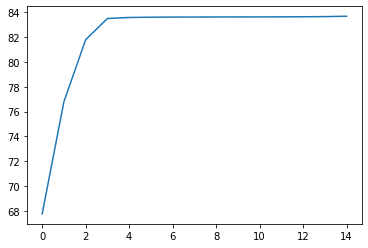

In [65]:
alpha, mu, sigma, log_likeh, label = EM_kmeans(X, 3, 15)
print(alpha)
print(label)
plt.plot(log_likeh)

In [62]:
cluster = [np.where(label==j) for j in range(3)]
mean_cluster = [ np.mean(X[cluster[j]], axis=0) for j in range(3)]

for j in range(3):
  print('The cluster', j+1, 'contains:', cluster[j])

The cluster 1 contains: (array([ 0,  3,  5,  8,  9, 10, 12, 20, 24, 31, 33, 38]),)
The cluster 2 contains: (array([ 1,  4, 13, 14, 15, 16, 18, 25, 26, 30, 32, 40]),)
The cluster 3 contains: (array([ 2,  6,  7, 11, 17, 19, 21, 22, 23, 27, 28, 29, 34, 35, 36, 37, 39]),)


In [43]:
tab = pd.DataFrame(data=mean_cluster, columns=name, index=[1,2,3])
tab.head()

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
1,11.024615,7.306154,14.516923,1.990000,49.901538,14.566923,44.583077,4.838462,56.076923,281.750769
2,10.925455,7.254545,15.342727,2.029091,49.585455,14.515455,47.802727,4.658182,62.889091,278.806364
3,11.024706,7.228235,13.886471,1.932941,49.418235,14.694118,41.878824,4.771765,57.070588,277.081765


We show some cluster two dimension by two dimension, this permit to see which pair of sports are well separted by the clusters
(if the cluster are mix this mean the two sport are corelated).

In [41]:
def draw_95_ellipse(mu, Sigma, c="black", alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(Sigma)
    axa = np.sqrt(eigenvalues[0] * 5.991)
    axb = np.sqrt(eigenvalues[1] * 5.991)
    va = eigenvectors[:, 0]
    vb = eigenvectors[:, 1]
    x = np.linspace(0, 2*np.pi, 100)
    trace = np.array([np.cos(e)*va*axa + np.sin(e)*vb*axb + mu for e in x])
    plt.plot(trace[:,0], trace[:,1], c=c, alpha=alpha, linewidth=3)

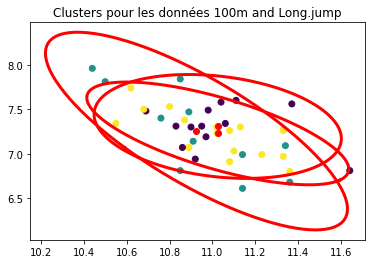

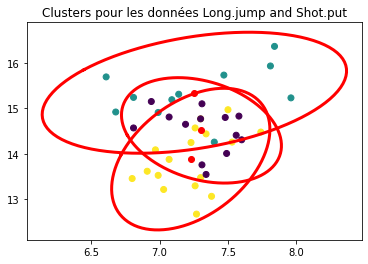

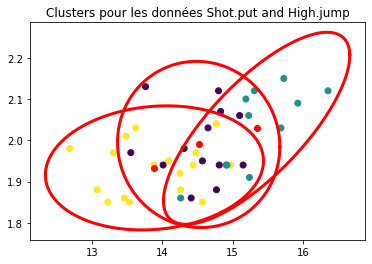

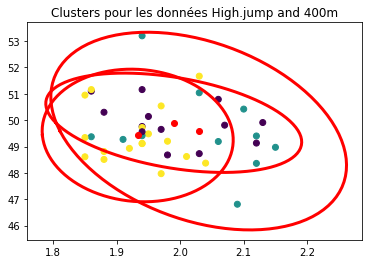

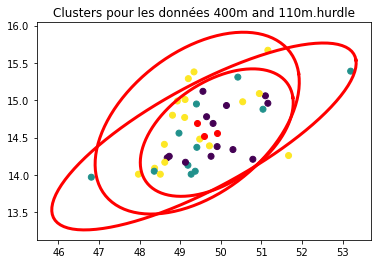

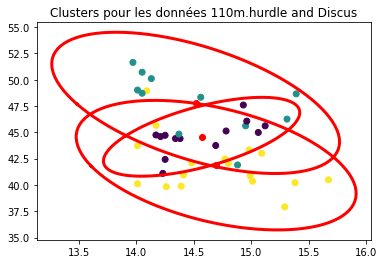

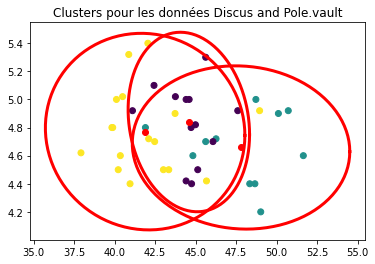

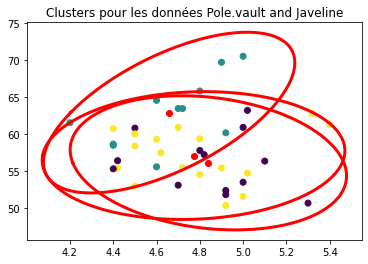

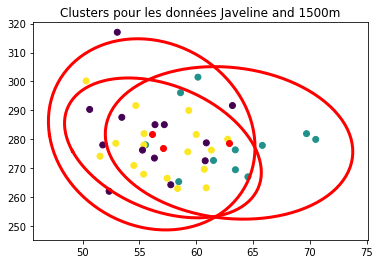

In [51]:
for j in range(9):  
  W = X[:,j:j+2]
  mu12 = mu[:,j:j+2]
  sigma12 = sigma[:,j:j+2,j:j+2]

  for k in range(3):
      draw_95_ellipse(mu12[k], sigma12[k], c="red", alpha=1)
  plt.scatter(mu12[:,0], mu12[:,1], c="red", zorder=10)
  plt.scatter(W[:,0], W[:,1], c=label)
  plt.title('Clusters pour les données ' + name[j] + ' and ' + name[j+1])
  plt.show()